In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, KFold, RepeatedKFold, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
import joblib
import lightgbm as lgb
import os

In [2]:
def split_features_and_labels(dataframe: pd.DataFrame) -> pd.DataFrame:
    features = dataframe.iloc[:, :-11]  # All columns except the last eleven
    labels = dataframe.iloc[:, -11:]    # The last eleven columns
    return features, labels

In [3]:

# Load embeddings data
embeddings_file = "data/image_embeddings.pt"

embeddings_dict = torch.load(embeddings_file)

products = pd.read_csv('data/product_with_attributes.csv')
embeddings = [embeddings_dict[filename] for filename in products['des_filename']]

# embeddings = [embedding.numpy() for embedding in embeddings]

features, labels = split_features_and_labels(products)

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Add each dimension as a separate feature
for i in range(512):
    features[f'embedding_dim_{i}'] = embeddings_array[:, i]

label_encoder_dict = {}
encoded_labels = pd.DataFrame()
for label in labels.columns:
    label_encoder = LabelEncoder()
    encoded_labels[label] = label_encoder.fit_transform(labels[label])
    label_encoder_dict[label] = label_encoder
    

/tmp/ipykernel_89586/1572149312.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load(embeddings_file)
/tmp/ipykernel_89586/1572149312.py:18: Sett

In [4]:
features = features.drop('cod_modelo_color', axis=1)
features = features.drop('des_filename', axis=1)
features.head(1)

,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_color,embedding_dim_0,...,embedding_dim_502,embedding_dim_503,embedding_dim_504,embedding_dim_505,embedding_dim_506,embedding_dim_507,embedding_dim_508,embedding_dim_509,embedding_dim_510,embedding_dim_511
0,Female,Kids,KIDS,TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,ROSA LIGHT,0.088515,...,0.252419,-0.853426,-0.126018,-0.65395,0.638628,0.435513,0.365749,0.165159,0.394995,0.221404


In [5]:
features_arr = np.array(features)

In [6]:
invalid_types = torch.load('invalid_types.pth')
X_train_dict = dict()
y_train_dict = dict()
X_test_dict = dict()
y_test_dict = dict()
    

feature_encoder_dict = dict()
for feature_idx in range(0, 9):
    le = LabelEncoder()
    features_arr[:, feature_idx] = le.fit_transform(features_arr[:, feature_idx])
    # print(le.classes_)
    # print(le.transform(le.classes_))
    feature_encoder_dict[feature_idx] = le

/tmp/ipykernel_89586/111119093.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  invalid_types = torch.load('invalid_types.pth')


In [ ]:
for label in labels.columns:
    transformed_features = feature_encoder_dict[7].inverse_transform(features_arr[:, 7].astype(int))

    mask = np.isin(transformed_features, invalid_types[label])

    filtered_features = features_arr[~mask]
    filtered_encoded_labels = encoded_labels[label][~mask]
    
    print(filtered_features.shape)
    
    X_train_dict[label], X_test_dict[label], y_train_dict[label], y_test_dict[label] = train_test_split(filtered_features, filtered_encoded_labels, test_size=0.1, random_state=42)
    # X_train_dict[label] = filtered_features
    # y_train_dict[label] = filtered_encoded_labels


(57923, 521)
(43788, 521)
(58894, 521)


# Train

In [ ]:
overfitted_labels = []

In [ ]:
for label in overfitted_labels
    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=4,            # Slightly reduced depth
        learning_rate=0.05,     # Moderately lower learning rate
        n_estimators=500,       # Reduced number of trees
        subsample=0.8,          # Use 80% of the data for each tree
        colsample_bytree=0.8,   # Use 80% of the features for each tree
        gamma=0.1,              # Regularization parameter
        reg_alpha=0.1,          # L1 regularization
        reg_lambda=0.1,         # L2 regularization
        random_state=42
    )

In [ ]:
for label in labels:
    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1,
        max_depth=5,                # Reduced depth
        learning_rate=0.01,         # Lower learning rate
        n_estimators=1000,          # Increased number of trees
        subsample=0.8,              # Use 80% of the data for each tree
        colsample_bytree=0.8,       # Use 80% of the features for each tree
        gamma=0.3,                  # Increased gamma for regularization
        min_child_weight=10,        # Increased to make the model more conservative
        reg_alpha=0.5,              # L1 regularization
        reg_lambda=1,               # L2 regularization
        random_state=42             # For reproducibility
    )

    print("Shape:", X_train_dict[label].shape)

    clf.fit(X_train_dict[label], y_train_dict[label])

    # Save the model
    model_filename = f"model_{label}_xgb_cat_4.joblib"
    joblib.dump(clf, model_filename)


    # Use XGBoost as an example
    # clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
    # clf = XGBClassifier( # MID
    #     use_label_encoder=False,
    #     eval_metric='mlogloss',
    #     n_jobs=-1,
    #     max_depth=8,
    #     learning_rate=0.1,
    #     n_estimators=200,
    #     # subsample=0.8,
    #     # colsample_bytree=0.8,
    #     gamma=0.1,
    #     min_child_weight=5
    # )

In [26]:
def print_model_accuracy(model):
    y_pred_test = model.predict(X_test_dict[label])
    accuracy_test = accuracy_score(y_test_dict[label], y_pred_test)
    y_pred_train = model.predict(X_train_dict[label])
    accuracy_train = accuracy_score(y_train_dict[label], y_pred_train)
    print(f"{label:^20}{accuracy_train:^20.4f}{accuracy_test:^20.4f}")

# Hyperparameter tuning for each label

571

In [60]:
label_sizes = [len(X_train_dict[label]) for label in labels]
label_sizes

[52130, 39409, 53004, 43106, 2159, 51992, 38117, 2159, 13210, 31014, 571]

In [45]:
big_labels = [label for label in labels if len(X_train_dict[label]) > 30_000]
medium_labels = [label for label in labels if 10_000 < len(X_train_dict[label]) < 30_000 ]
small_labels = [label for label in labels if len(X_train_dict[label]) < 10_000 ]


In [61]:
label = labels.columns[4]
label

'heel_shape_type'

In [ ]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


model = XGBClassifier(
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

random_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
random_search.fit(X_train_dict[label], y_train_dict[label])

best_model = random_search.best_estimator_

print_model_accuracy(best_model)

model_filename = f"model_{label}_xgb_cat_gridSearch.joblib"
joblib.dump(clf, model_filename)

In [ ]:
label = 'length_type'

In [ ]:
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.8, 1.0]
}

model = XGBClassifier(
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

random_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
random_search.fit(X_train_dict[label], y_train_dict[label])

best_model = random_search.best_estimator_

print_model_accuracy(best_model)

model_filename = f"model_{label}_xgb_cat_gridSearch.joblib"
joblib.dump(clf, model_filename)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [58]:
print(best_model.get_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.5, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [34]:
print_model_accuracy(best_model)

  cane_height_type         0.9965              0.7188       


# Plots

In [ ]:
models = {}

for label in labels:
    model_filename = f"model_{label}_xgb_cat_4.joblib"
    
    models[label] = joblib.load(model_filename)

/home/gerard/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:48:51] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [14]:
print(f"{'Label':^20}{'Train Accuracy':^20}{'Test Accuracy':^20}")
print('-' * 65)
for label in labels:
    model = models[label]
    y_pred_test = model.predict(X_test_dict[label])
    accuracy_test = accuracy_score(y_test_dict[label], y_pred_test)
    y_pred_train = model.predict(X_train_dict[label])
    accuracy_train = accuracy_score(y_train_dict[label], y_pred_train)
    print(f"{label:^20}{accuracy_train:^20.4f}{accuracy_test:^20.4f}")

       Label           Train Accuracy      Test Accuracy    
-----------------------------------------------------------------
  silhouette_type          0.9939              0.9929       
  neck_lapel_type          0.9989              0.9993       
  woven_structure          0.9938              0.9956       
   knit_structure          0.9997              0.9996       
  heel_shape_type          1.0000              1.0000       
    length_type            0.9953              0.9946       
 sleeve_length_type        0.9993              0.9995       
    toecap_type            0.9995              1.0000       
     waist_type            0.9980              0.9986       
 closure_placement         0.9989              0.9983       
  cane_height_type         0.9965              1.0000       



Accuracy for silhouette_type: 0.9936124298662063


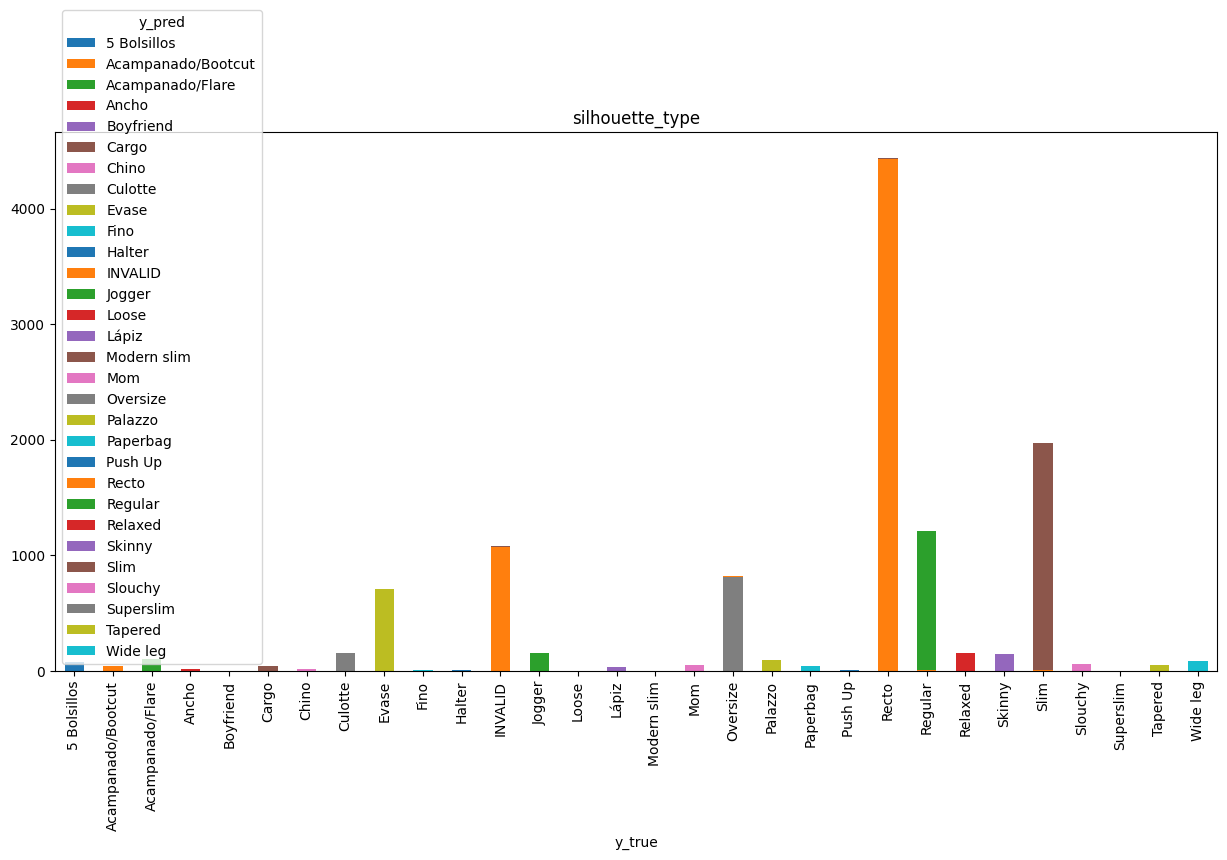


Accuracy for neck_lapel_type: 0.9993149120803837


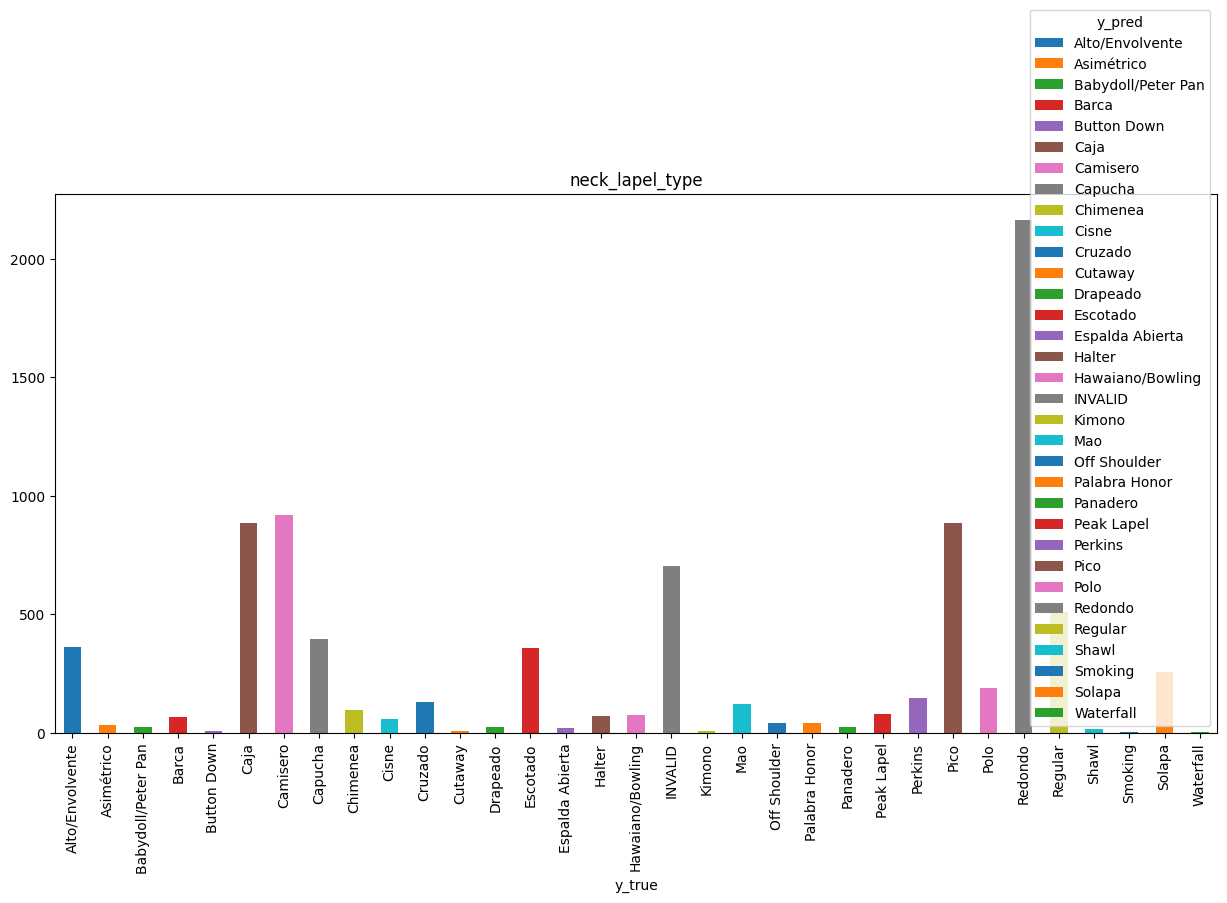


Accuracy for woven_structure: 0.9947363952797351


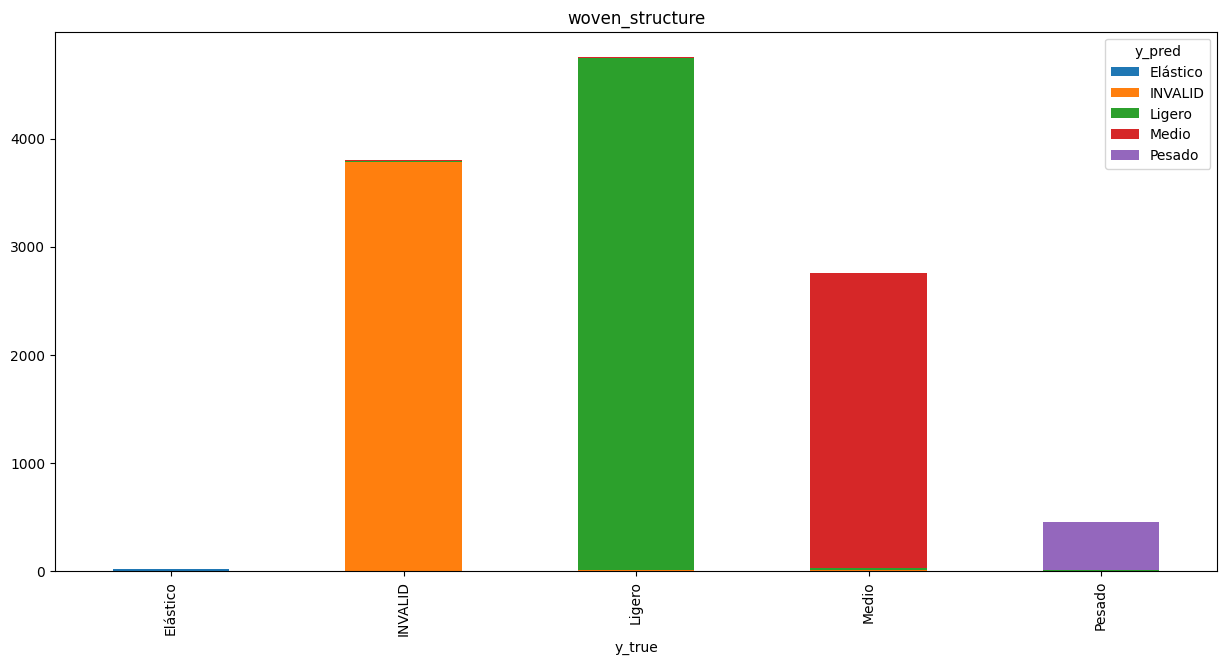


Accuracy for knit_structure: 0.9996868475991649


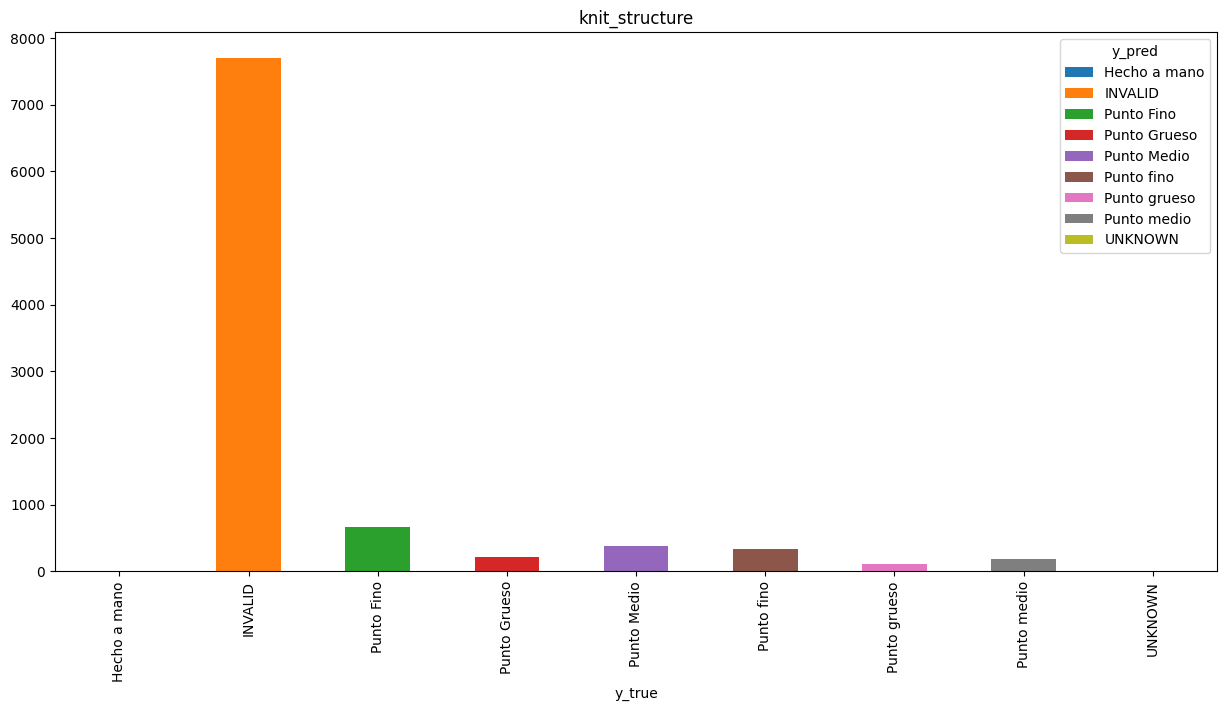


Accuracy for heel_shape_type: 1.0


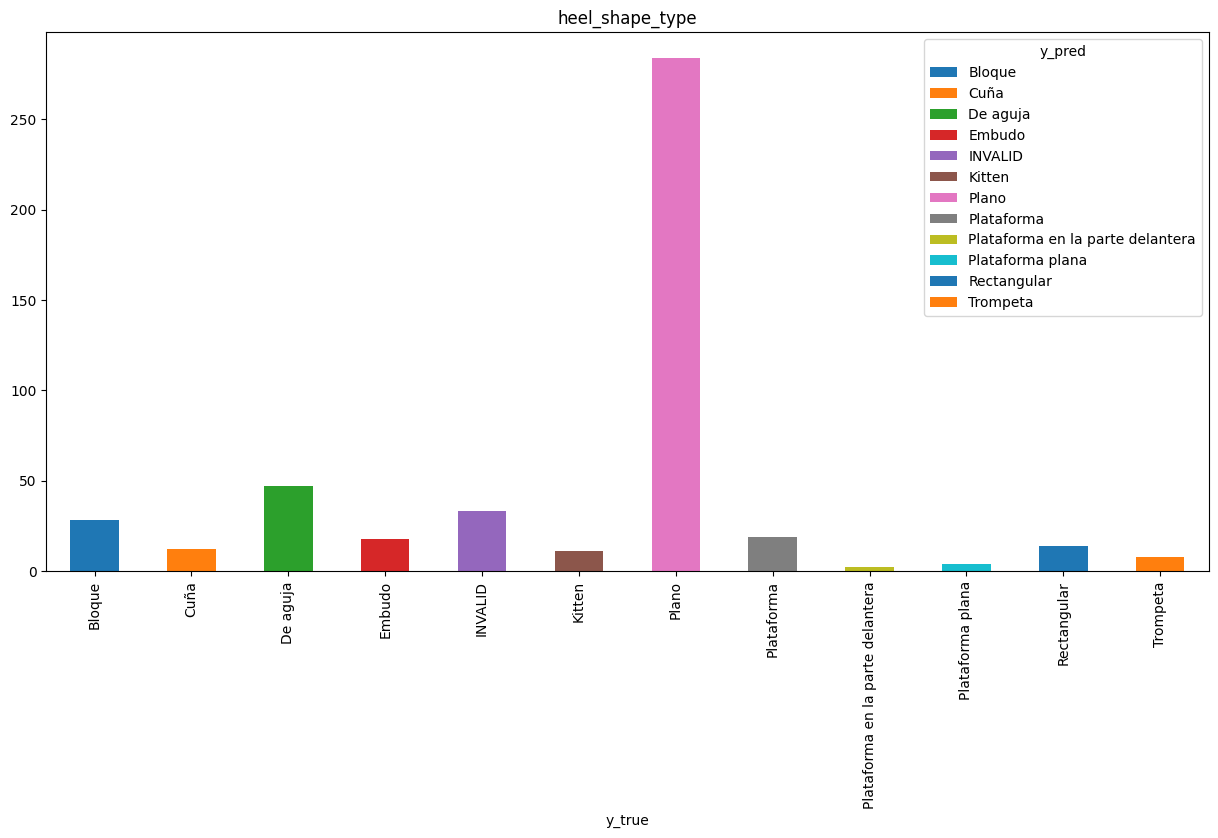


Accuracy for length_type: 0.9950666435866367


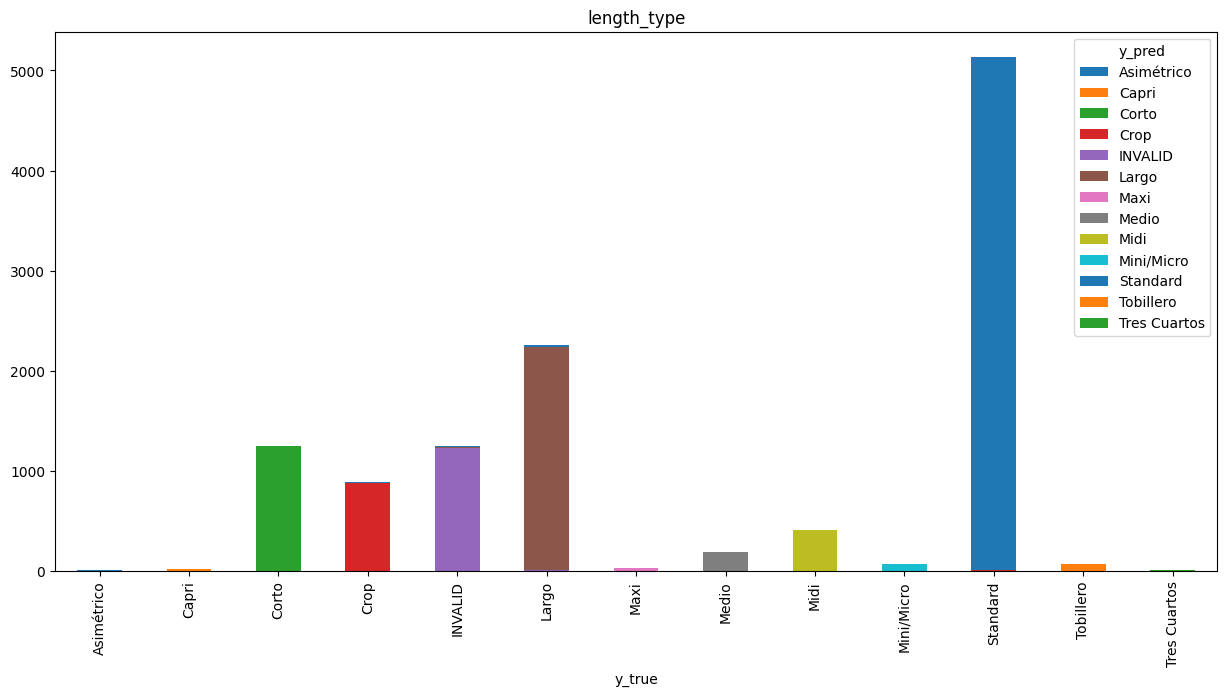


Accuracy for sleeve_length_type: 0.998937551646795


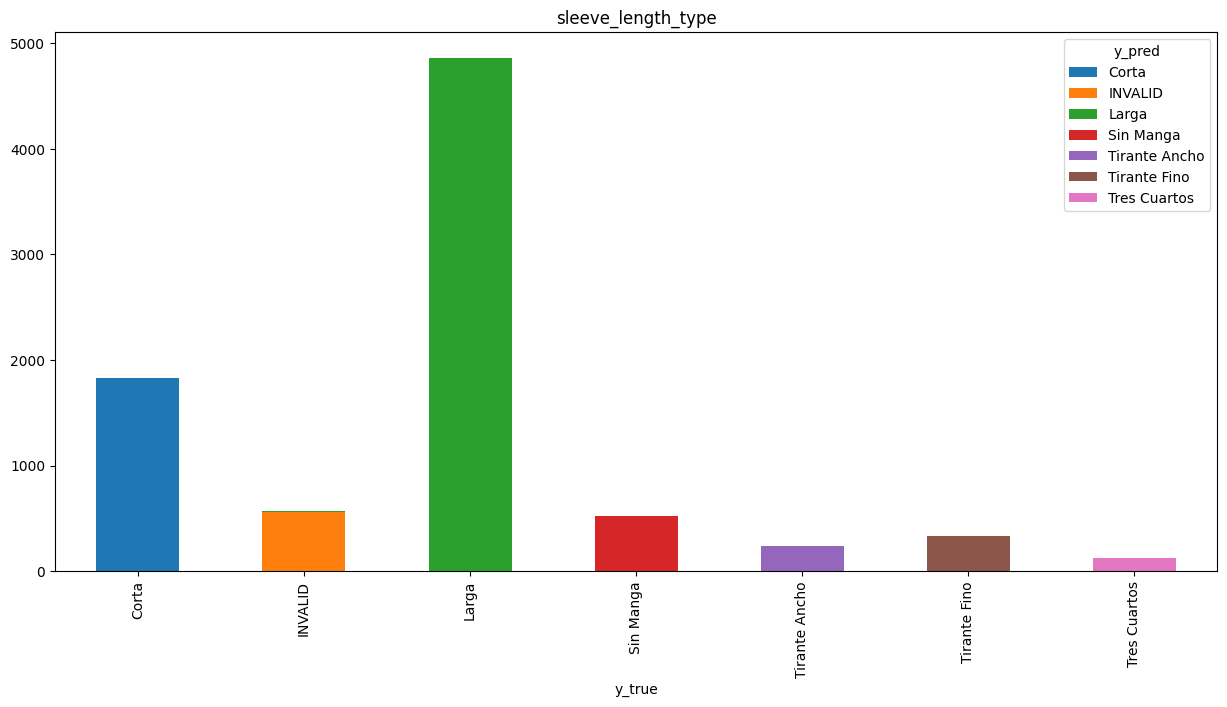


Accuracy for toecap_type: 1.0


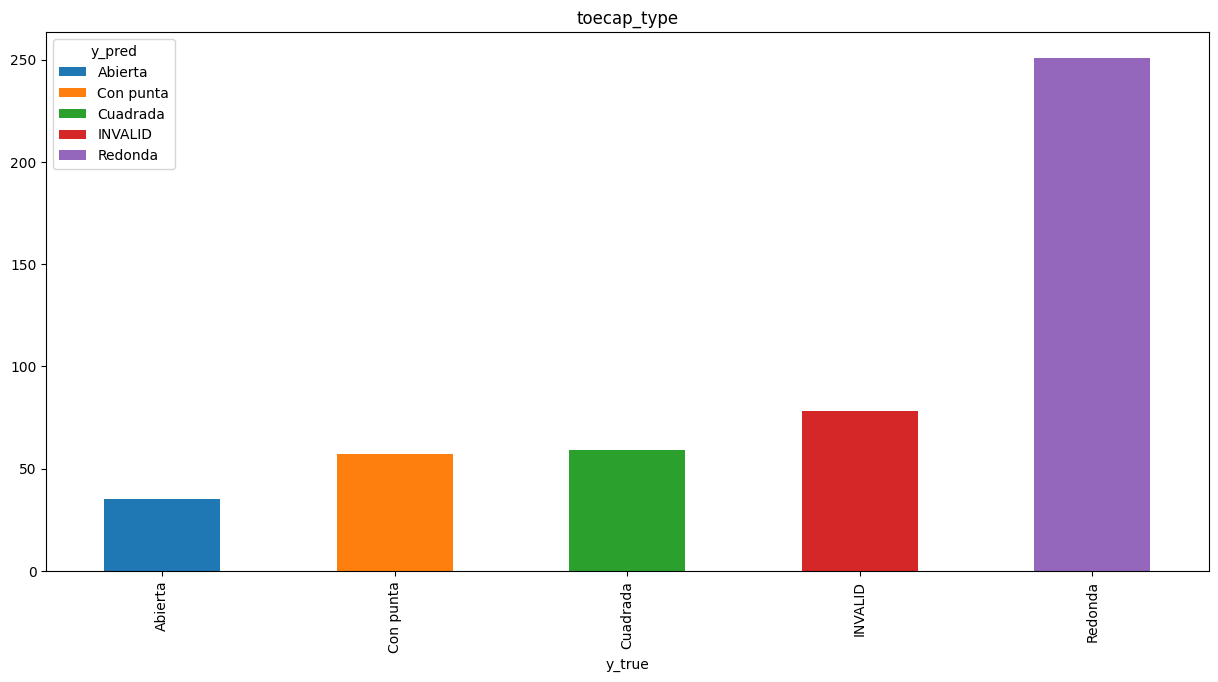


Accuracy for waist_type: 0.9982970027247956


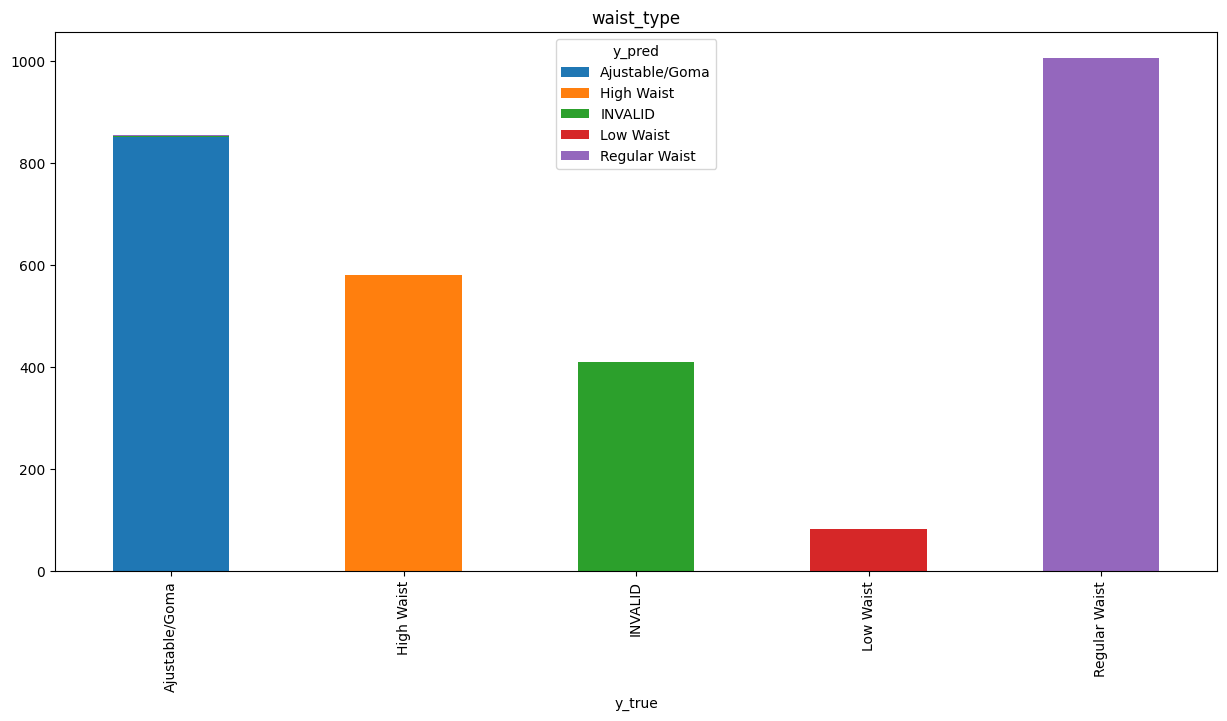


Accuracy for closure_placement: 0.9988394022921805


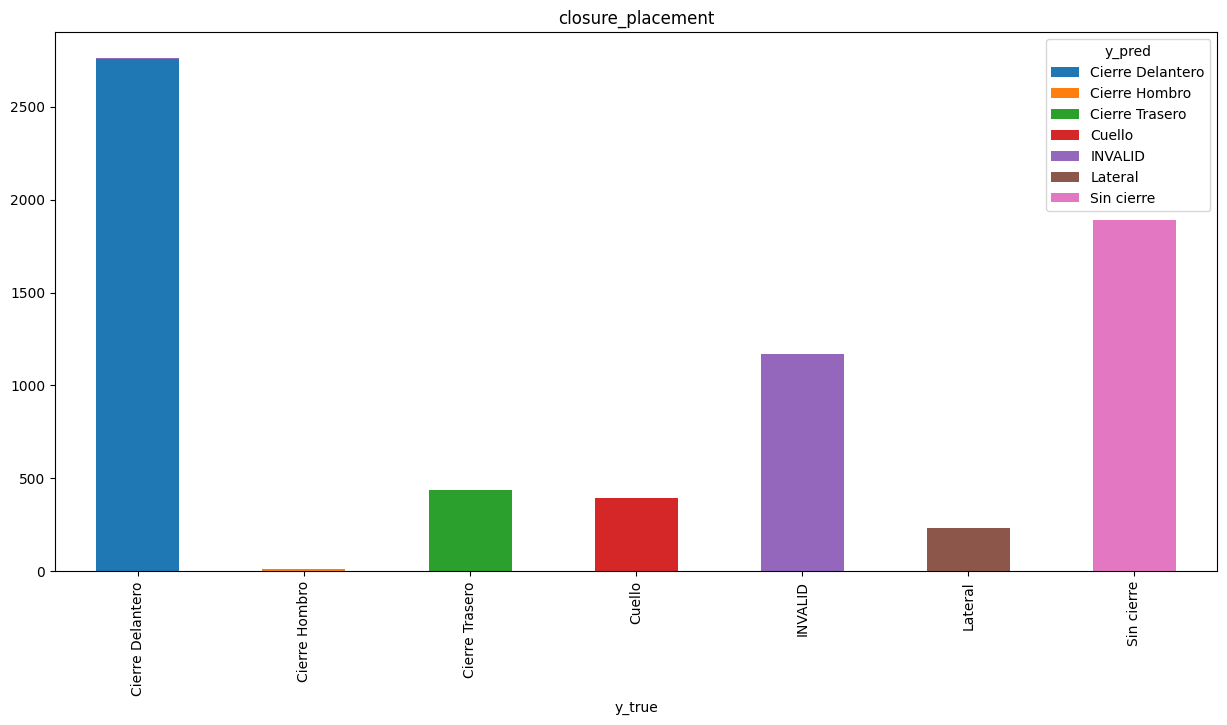


Accuracy for cane_height_type: 1.0


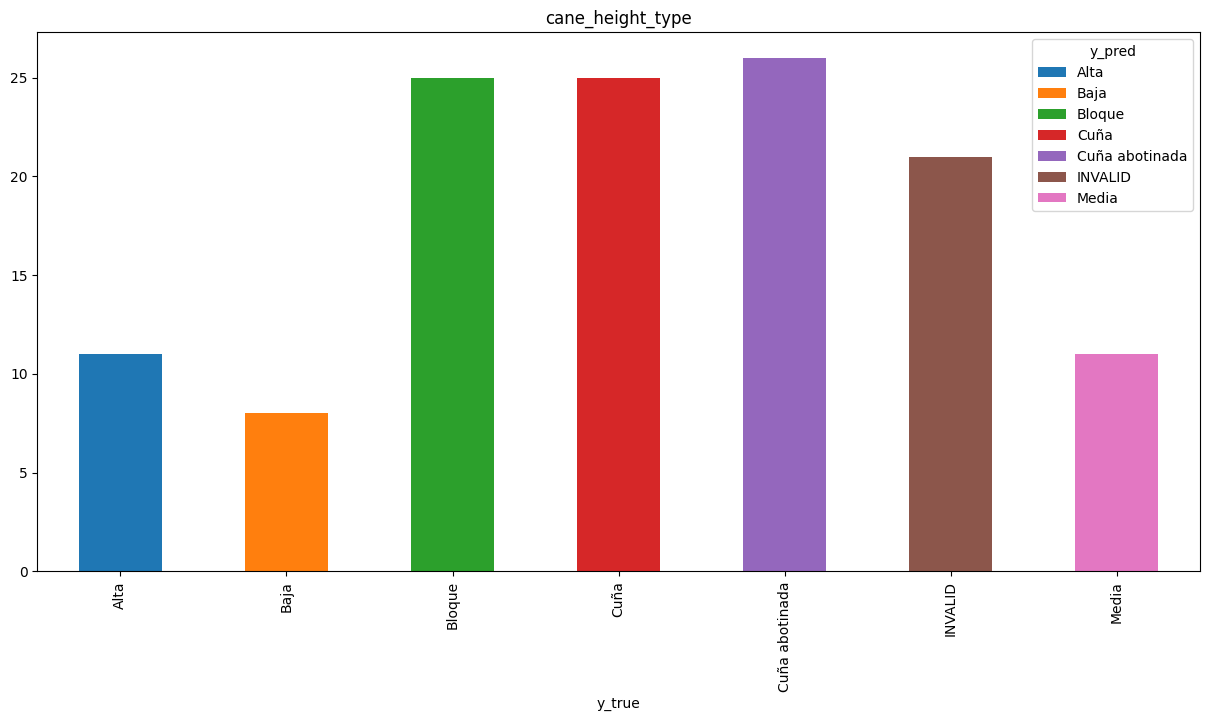

In [10]:
import matplotlib.pyplot as plt

for label in labels:
    model = models[label]
    y_pred = model.predict(X_test_dict[label])
    accuracy = accuracy_score(y_test_dict[label], y_pred)
    print(f"\nAccuracy for {label}: {accuracy}")

    # Map encoded labels back to original labels and reset index
    y_test_data = y_test_dict[label].apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0]).reset_index(drop=True)
    y_pred_data = pd.Series(y_pred).apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0]).reset_index(drop=True)

    # Create DataFrame without index alignment issues
    data = pd.DataFrame({'y_true': y_test_data, 'y_pred': y_pred_data})

    # Plot the results
    data.groupby('y_true')['y_pred'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 7))
    plt.title(f'{label}')
    plt.show()



Accuracy for silhouette_type: 0.993849540334067


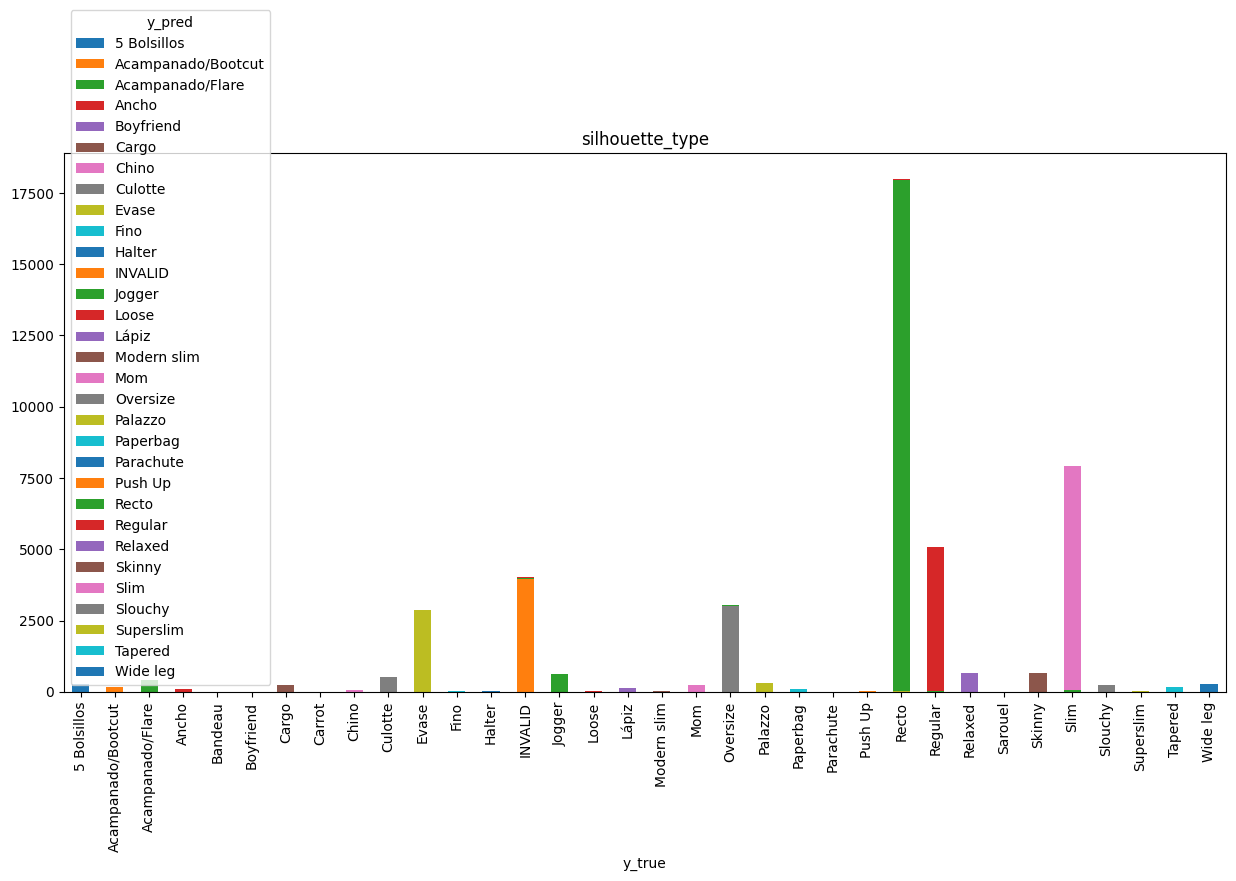


Accuracy for neck_lapel_type: 0.9988010276905509


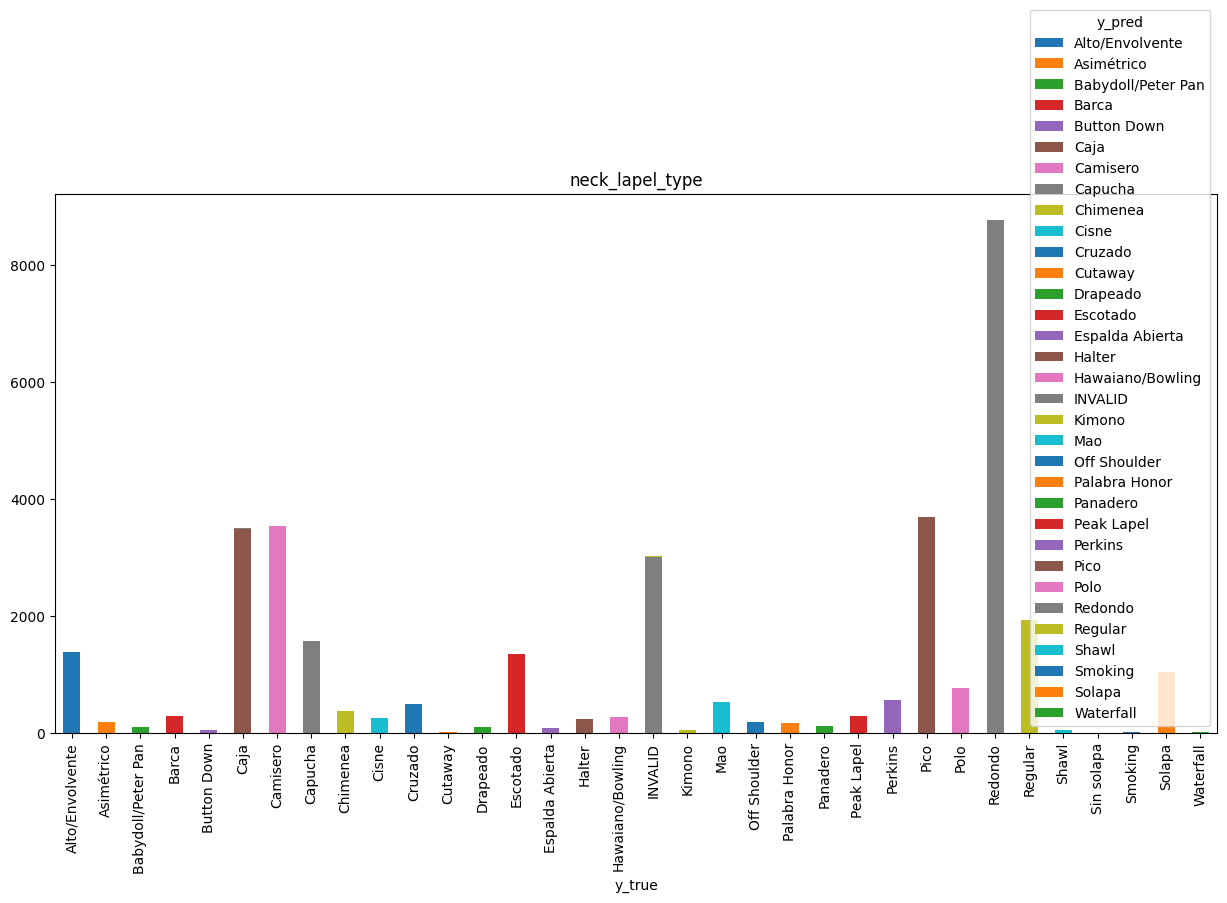


Accuracy for woven_structure: 0.9938236230499841


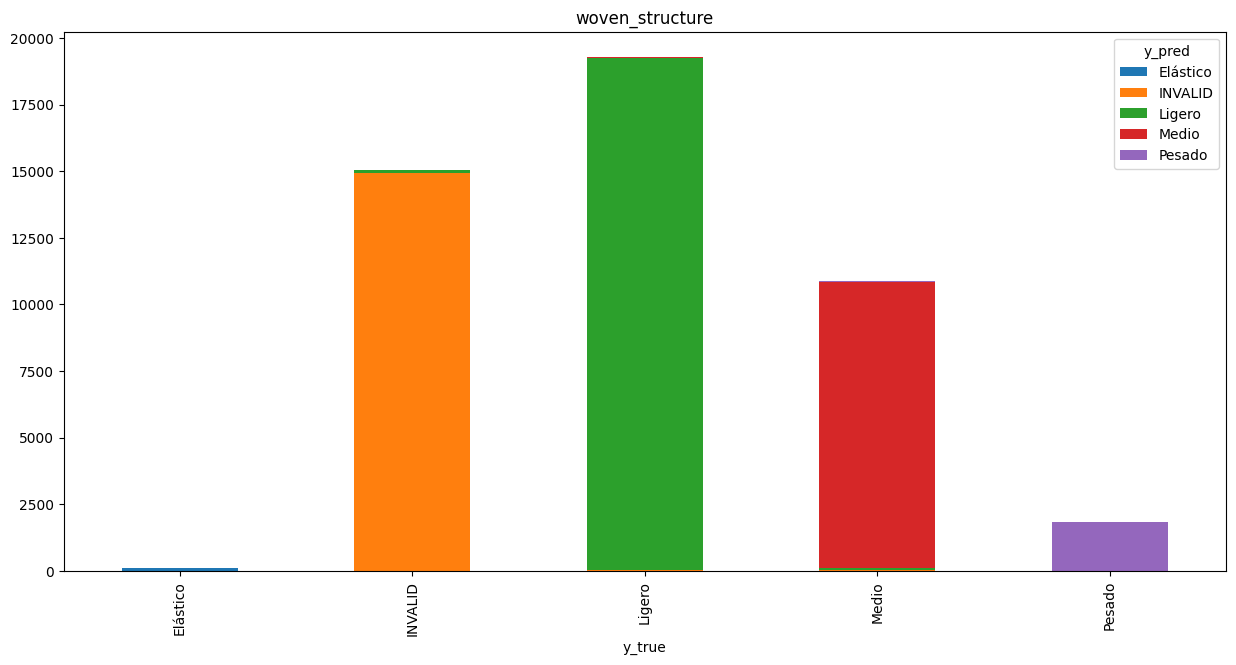


Accuracy for knit_structure: 0.9996607161499113


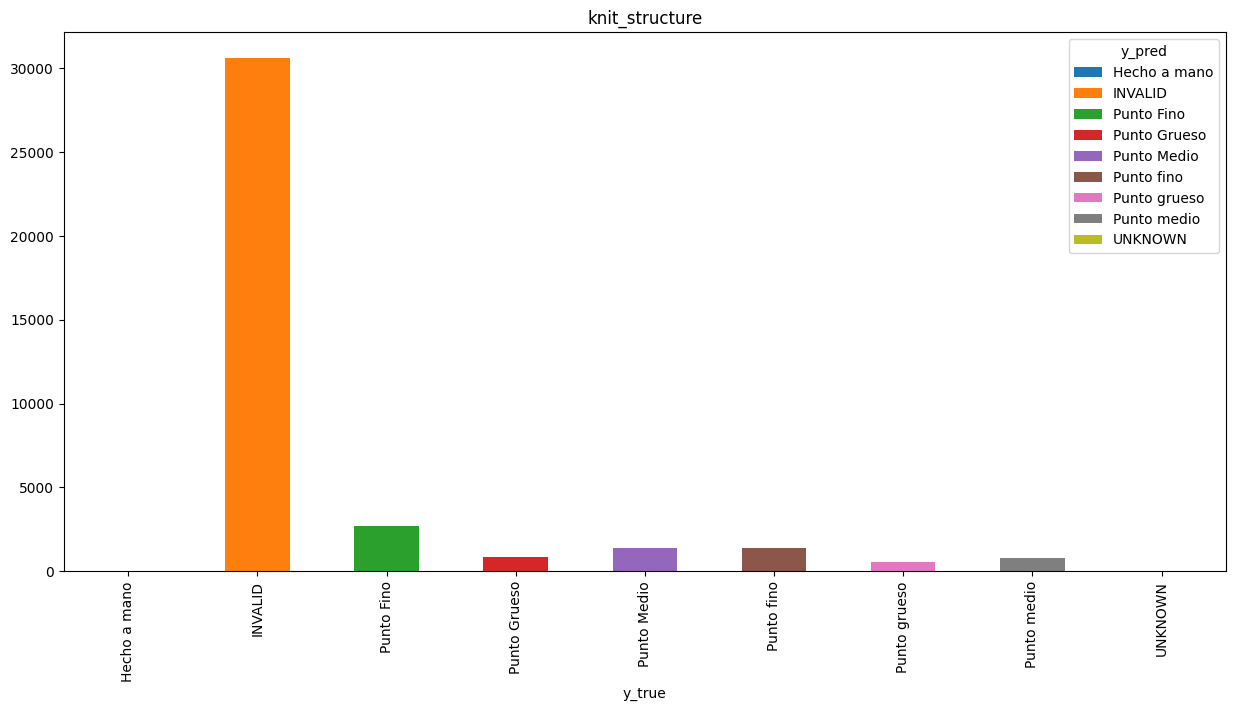


Accuracy for heel_shape_type: 1.0


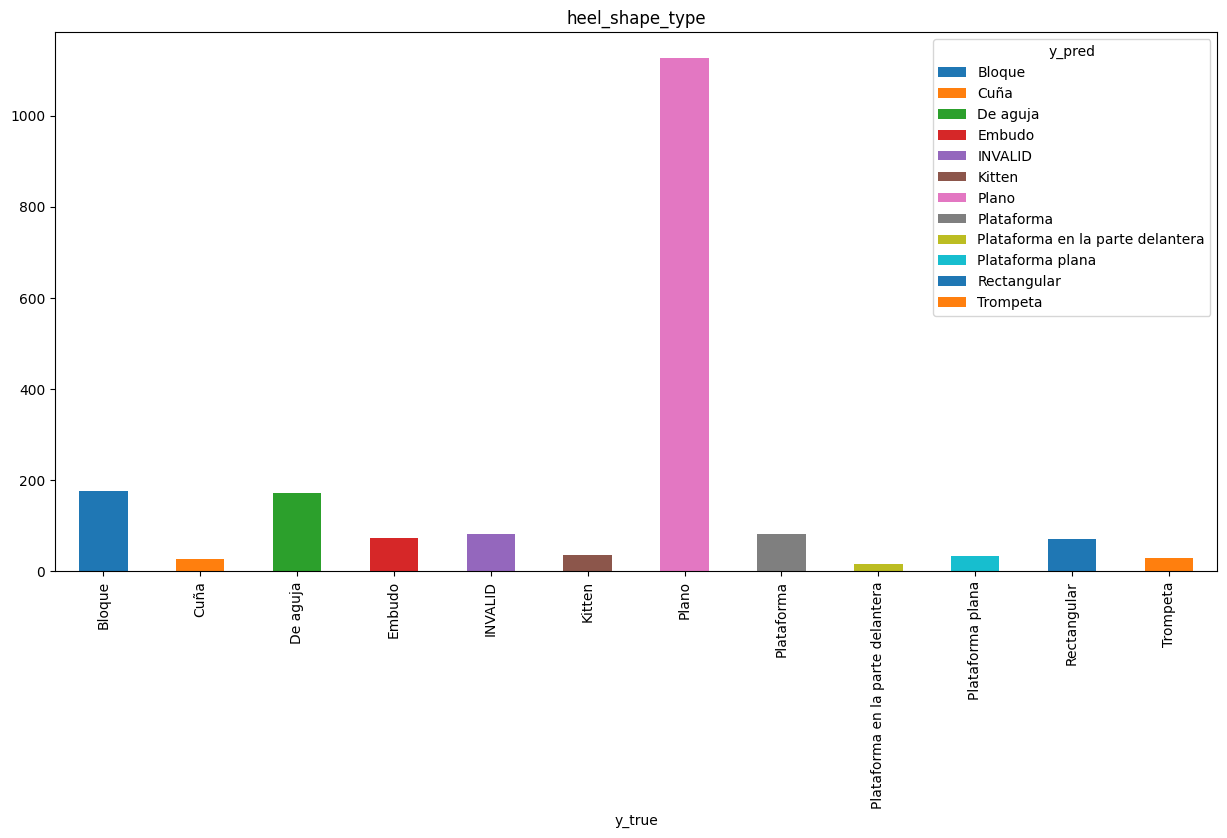


Accuracy for length_type: 0.9952396408092611


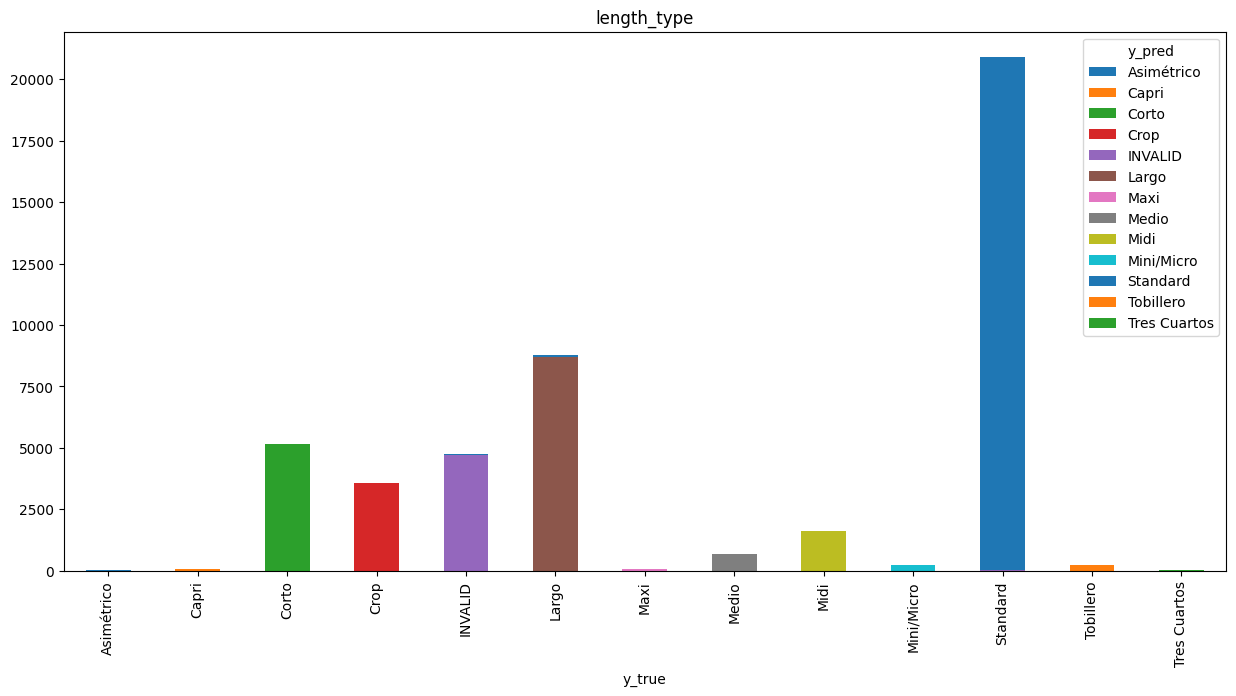


Accuracy for sleeve_length_type: 0.9994687444660882


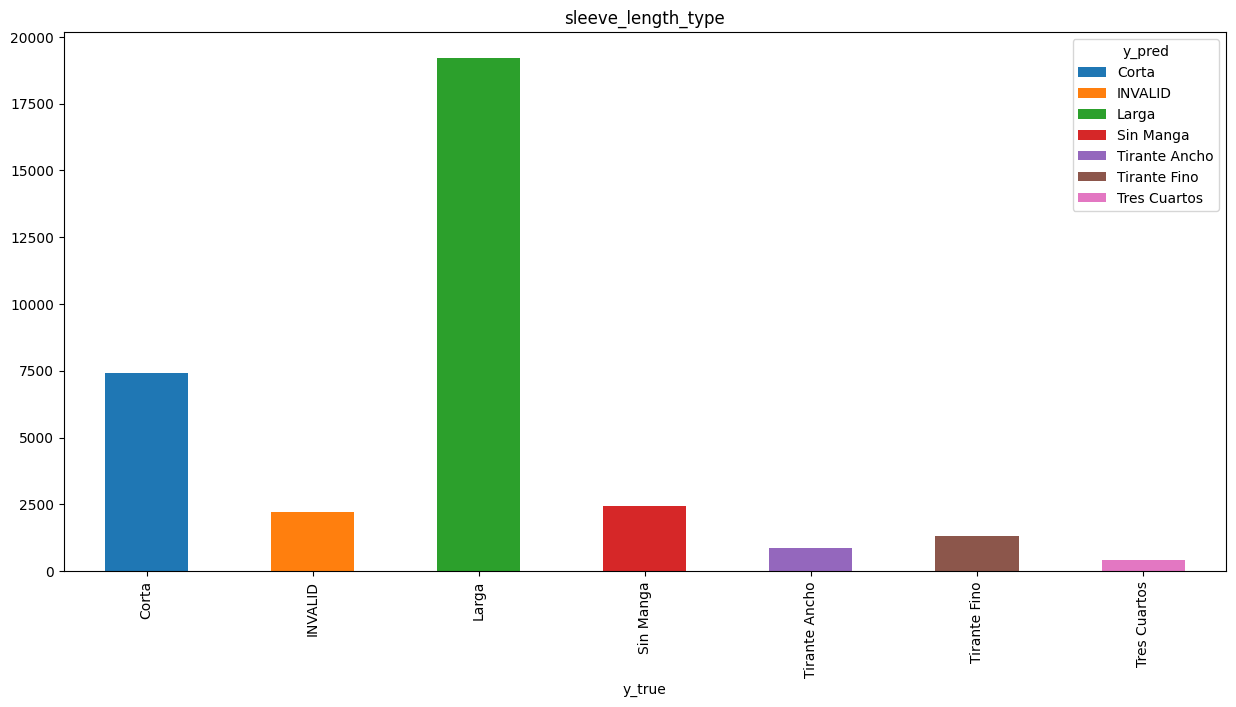


Accuracy for toecap_type: 0.9994788952579469


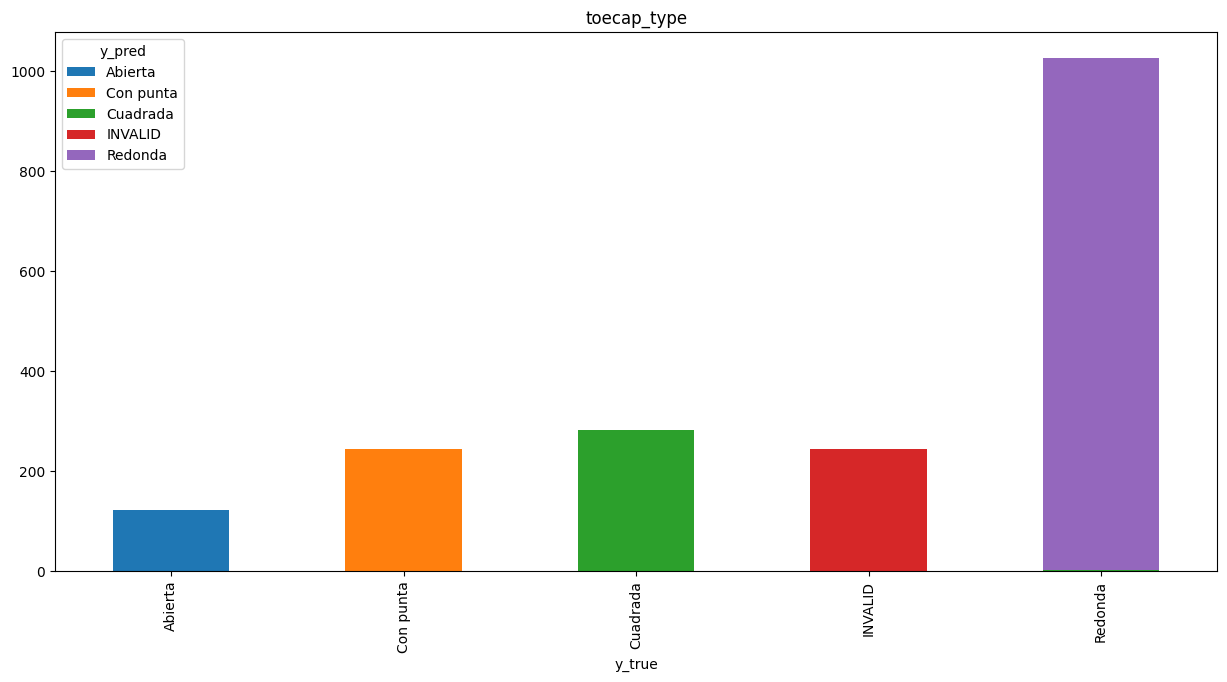


Accuracy for waist_type: 0.99795605518651


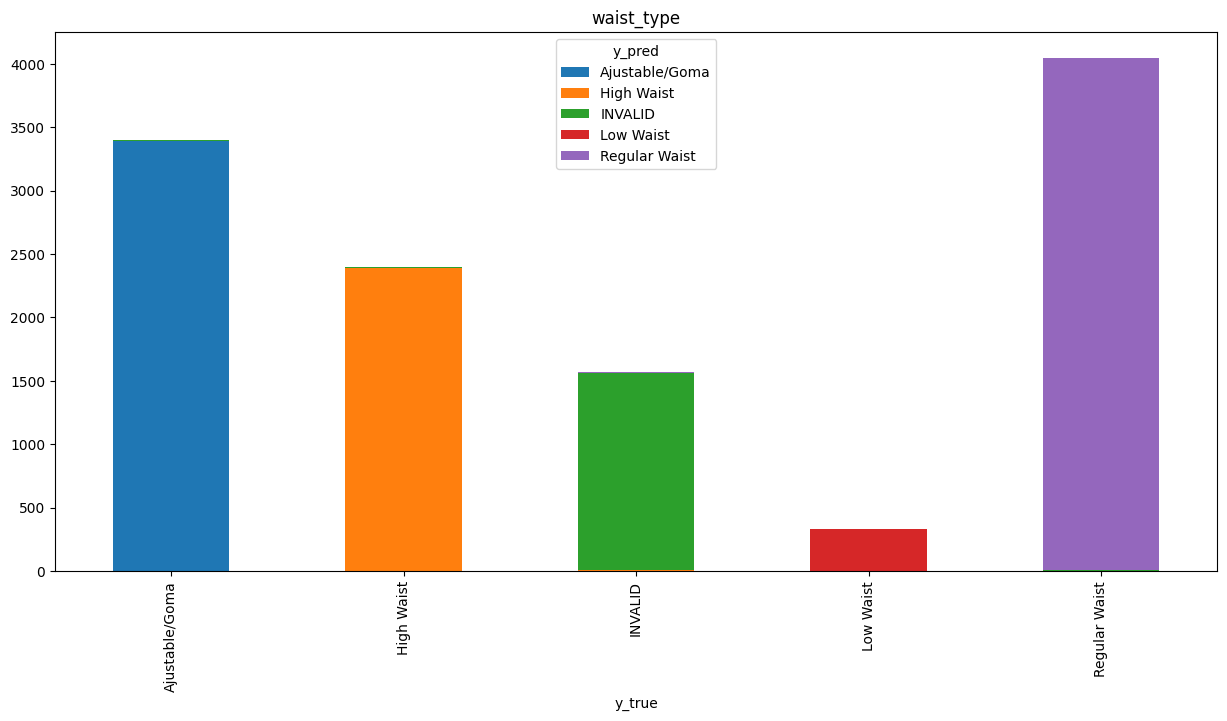


Accuracy for closure_placement: 0.9988392338943702


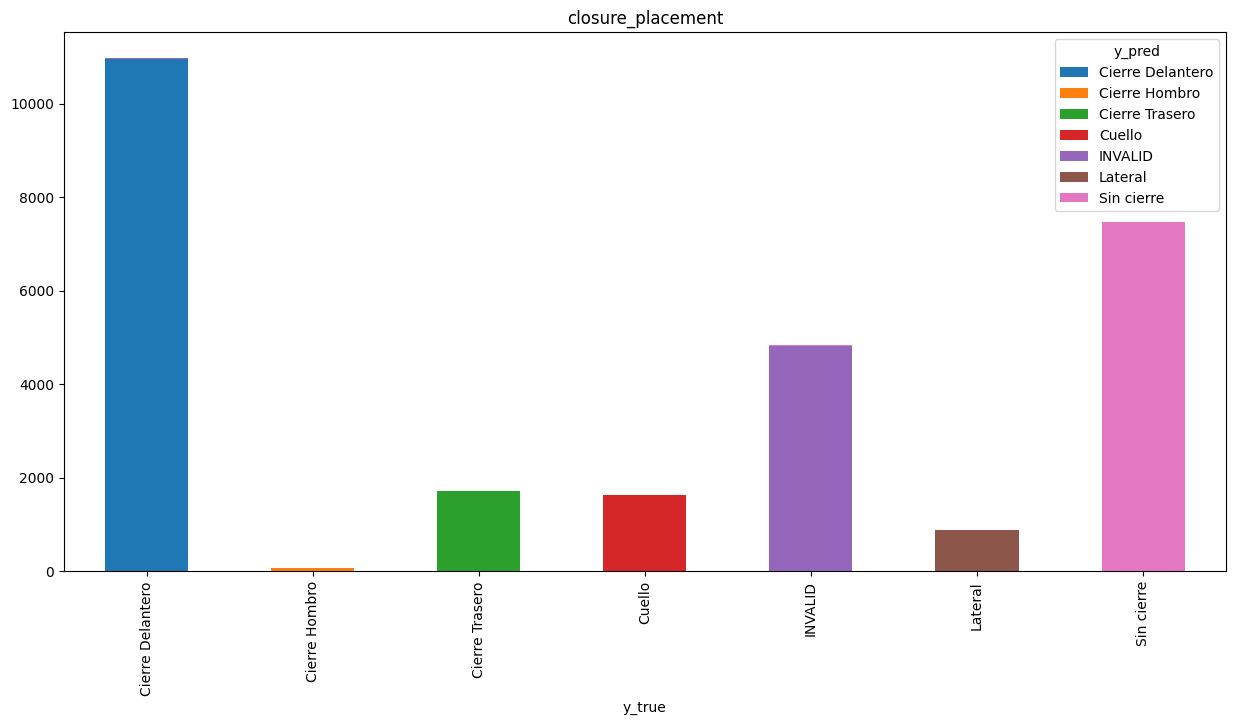


Accuracy for cane_height_type: 0.9960629921259843


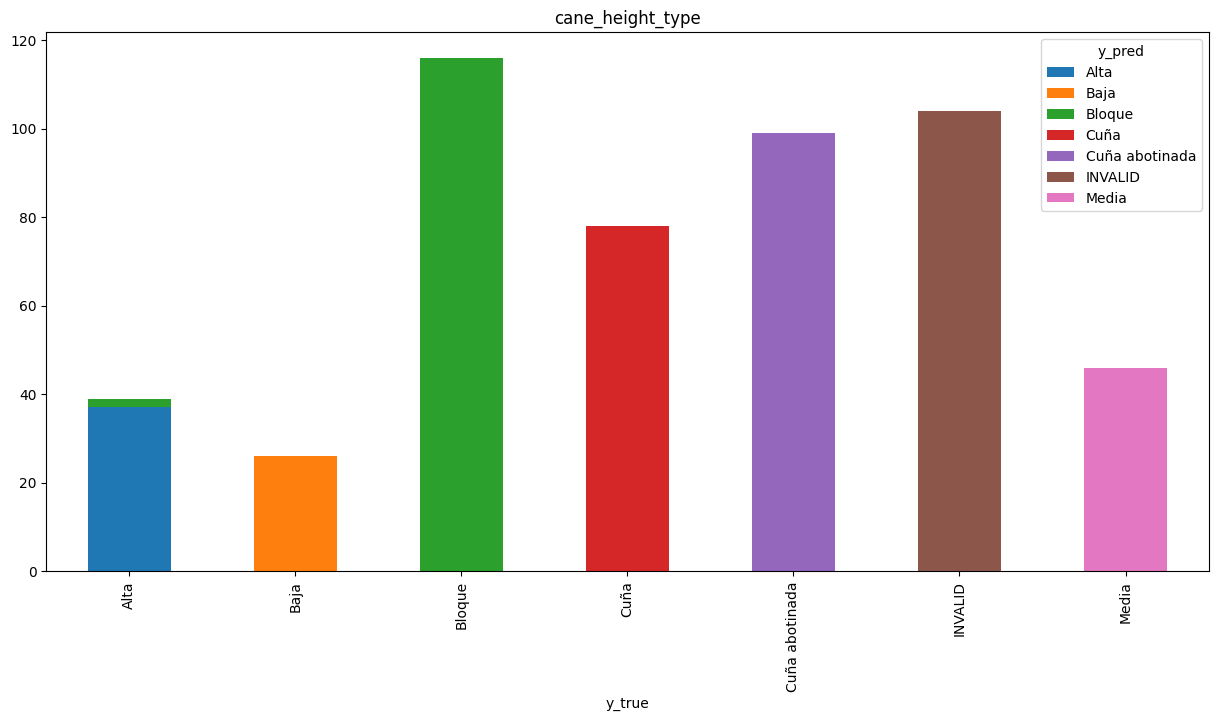

In [11]:
import matplotlib.pyplot as plt

for label in labels:
    model = models[label]
    y_pred = model.predict(X_train_dict[label])
    accuracy = accuracy_score(y_train_dict[label], y_pred)
    print(f"\nAccuracy for {label}: {accuracy}")

    # Map encoded labels back to original labels and reset index
    y_train_data = y_train_dict[label].apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0]).reset_index(drop=True)
    y_pred_data = pd.Series(y_pred).apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0]).reset_index(drop=True)

    # Create DataFrame without index alignment issues
    data = pd.DataFrame({'y_true': y_train_data, 'y_pred': y_pred_data})

    # Plot the results
    data.groupby('y_true')['y_pred'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 7))
    plt.title(f'{label}')
    plt.show()


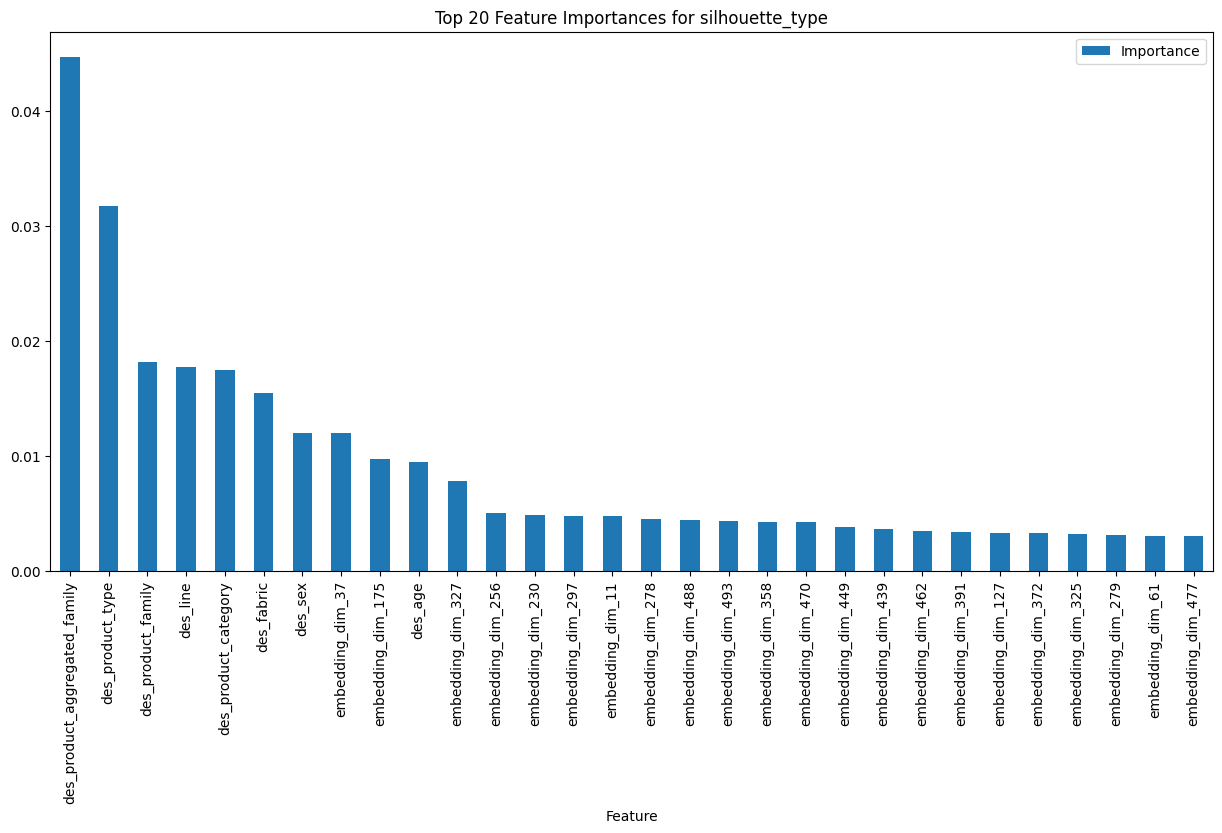

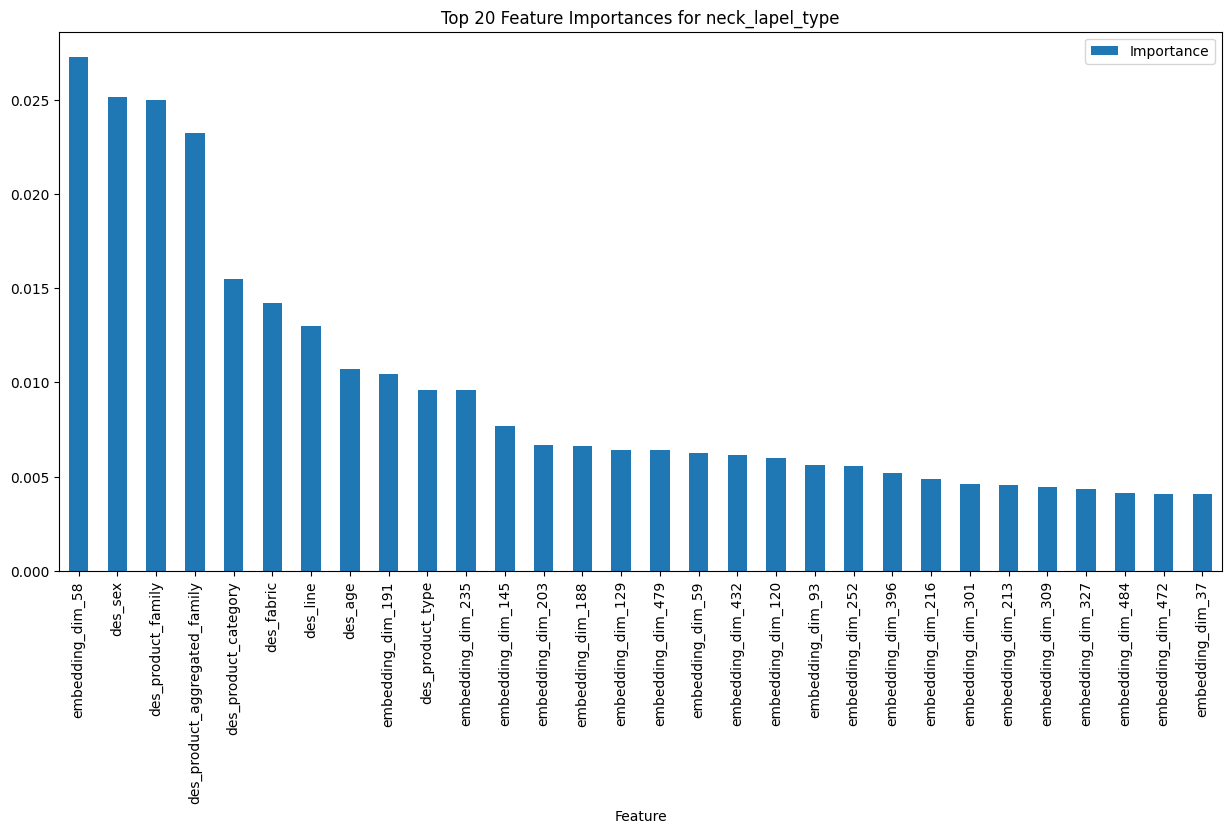

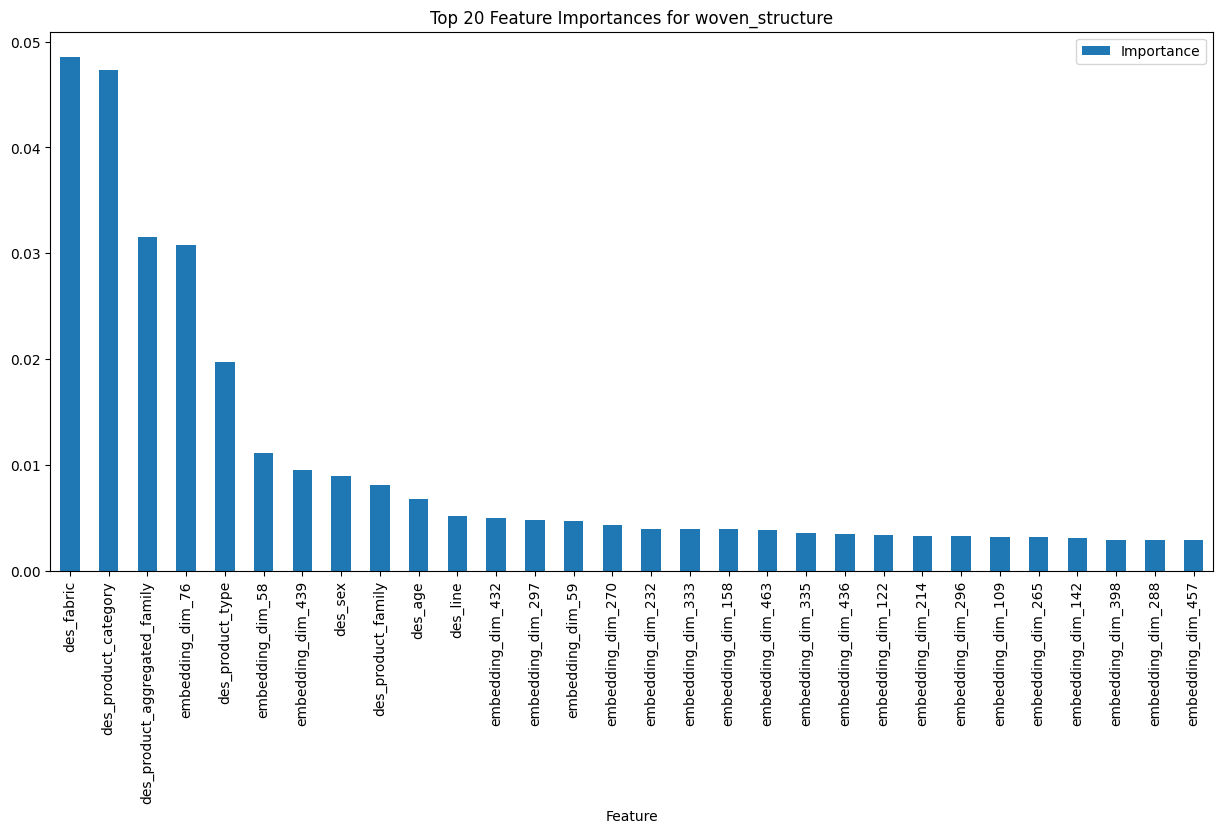

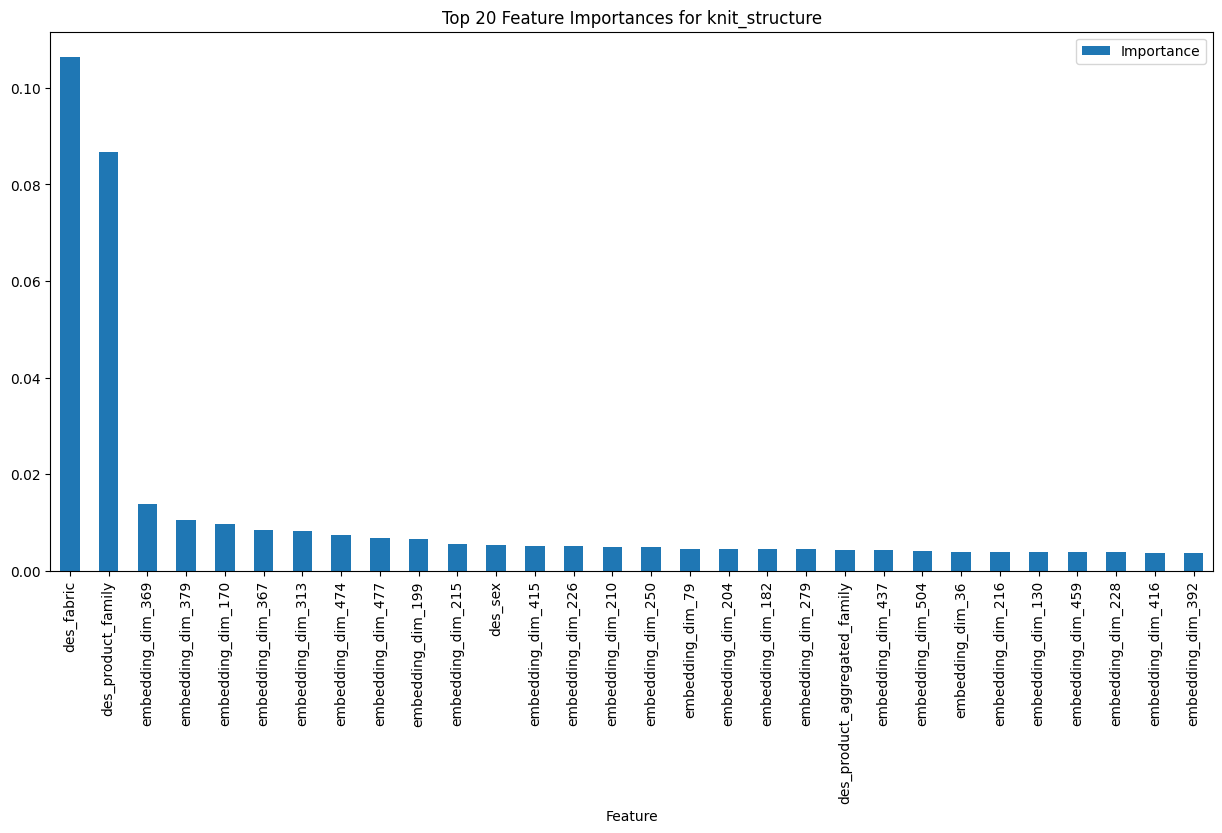

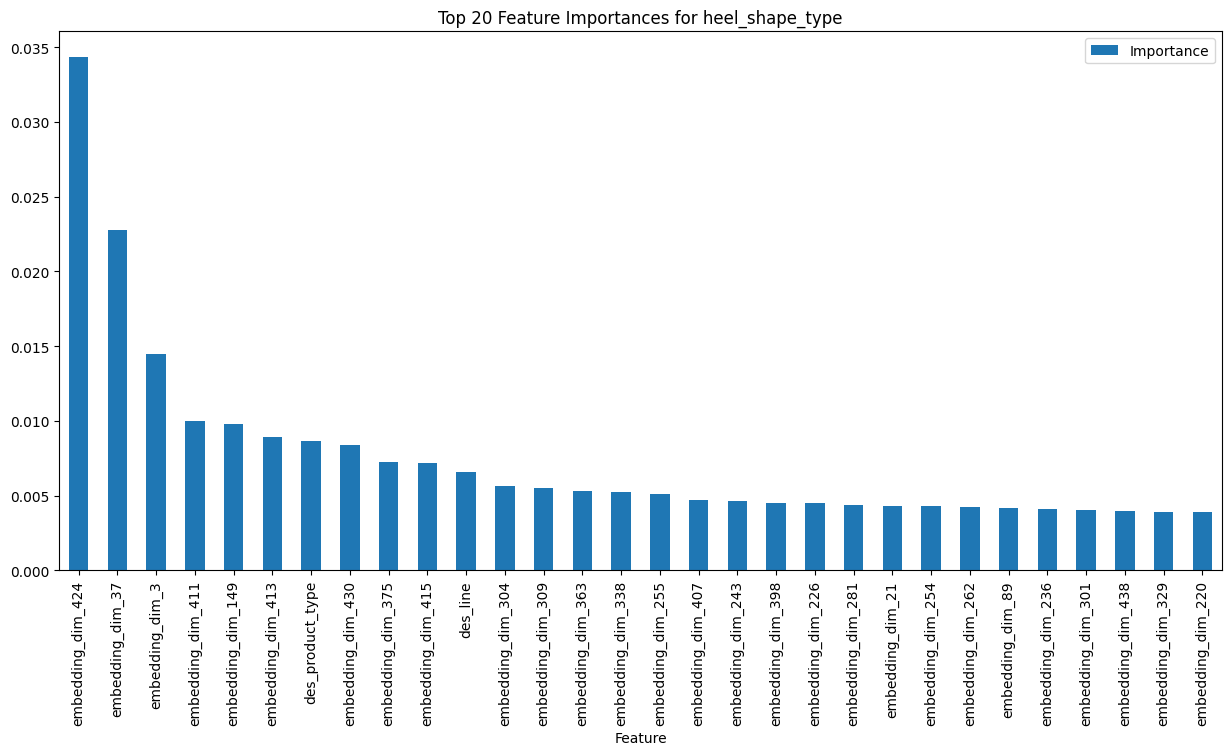

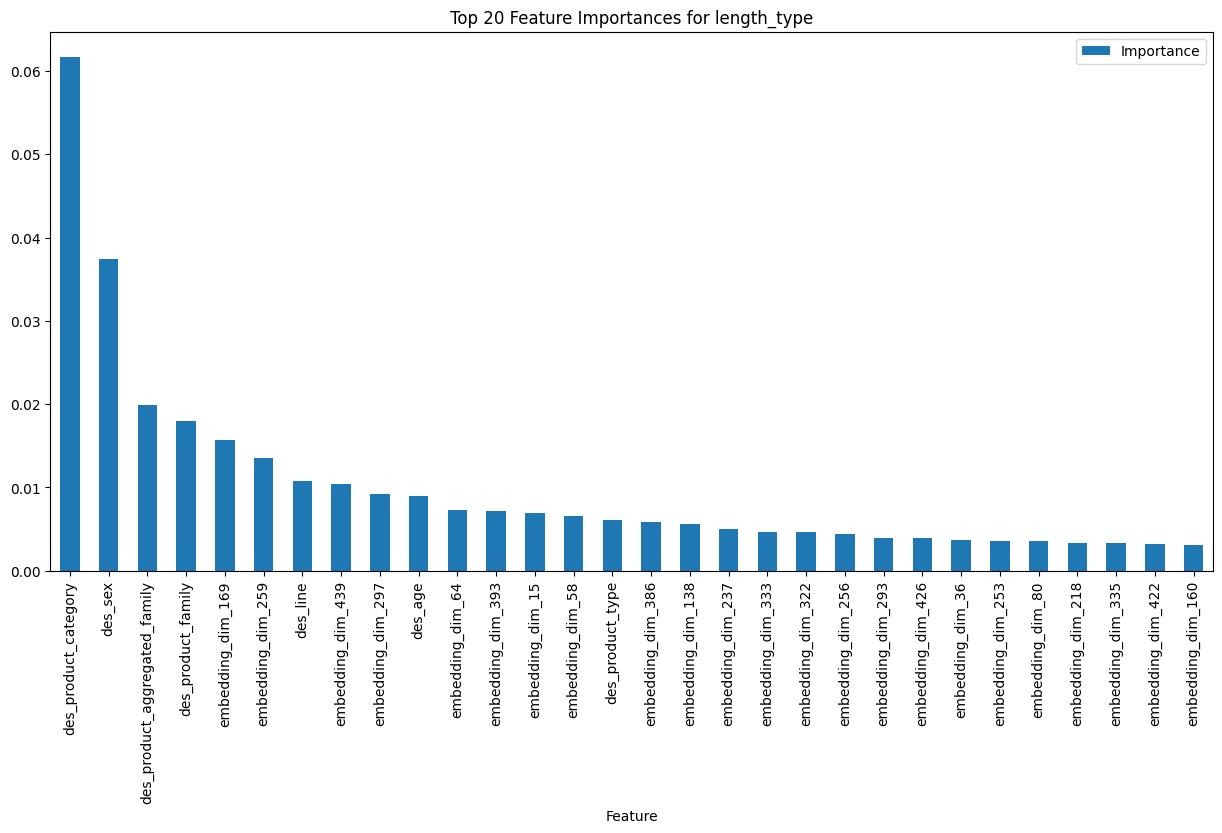

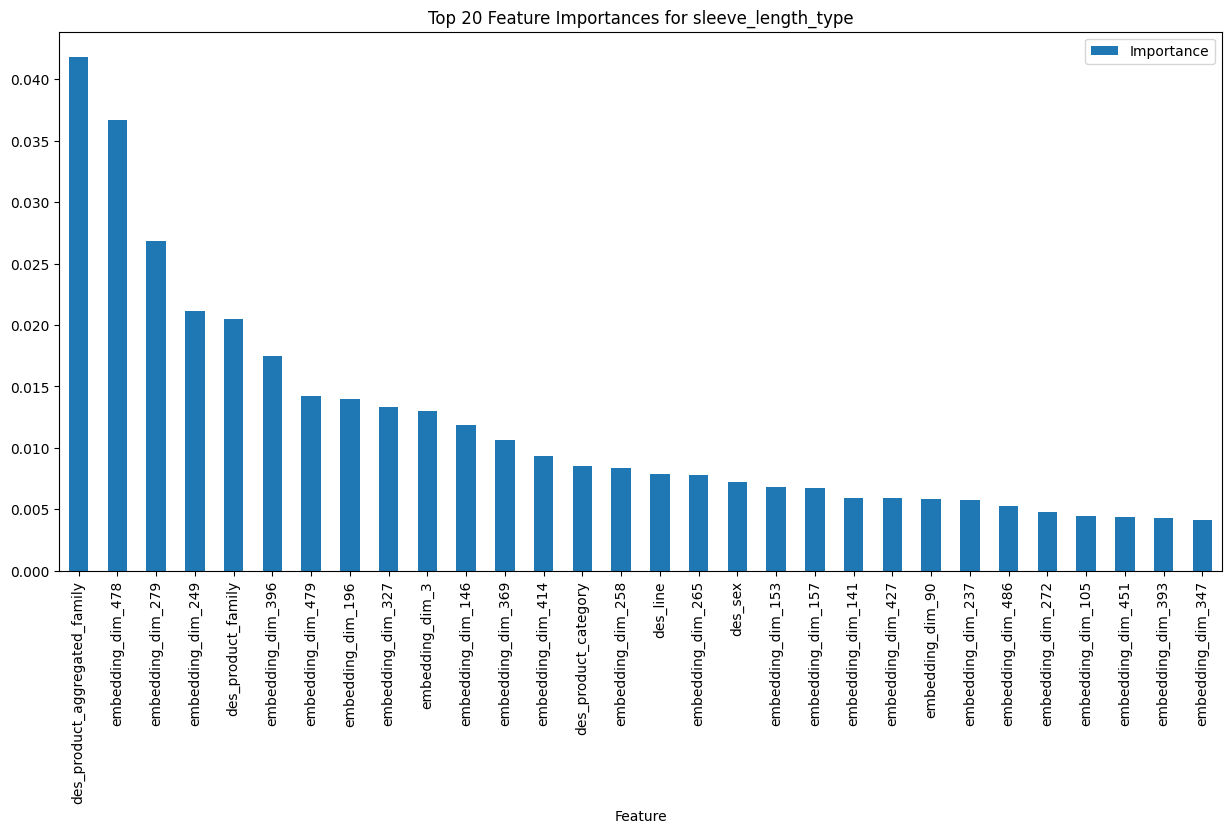

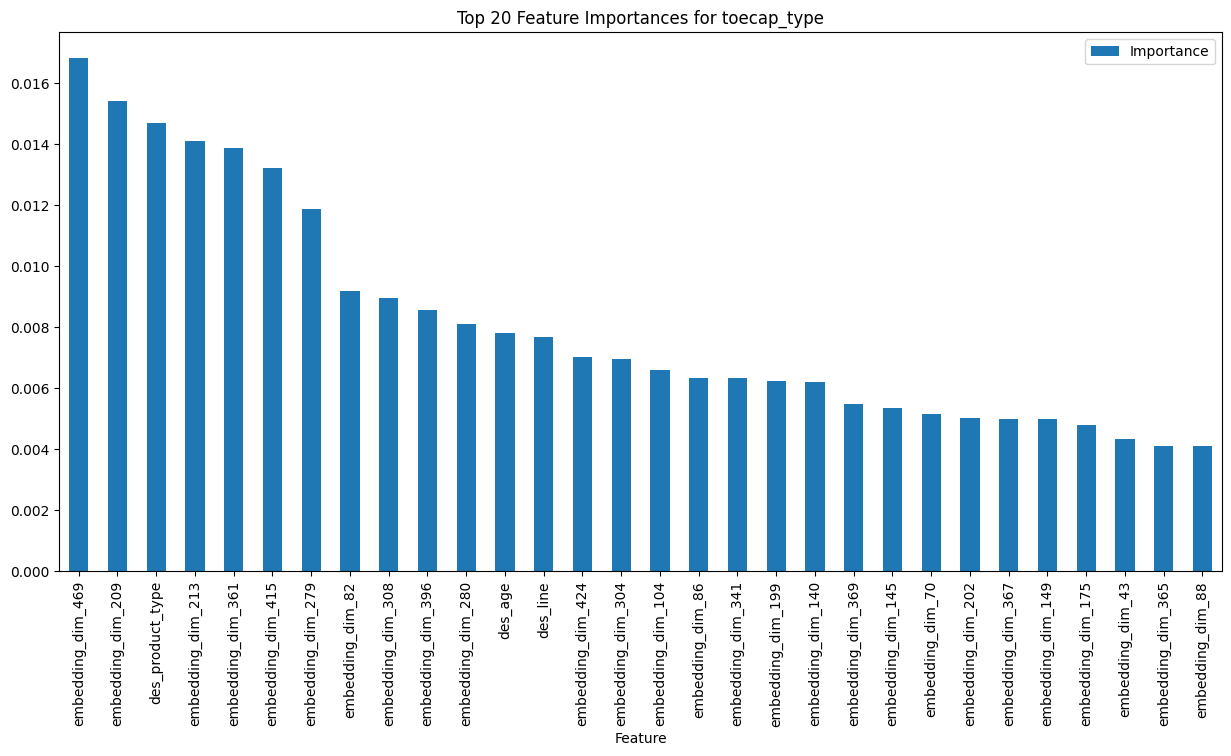

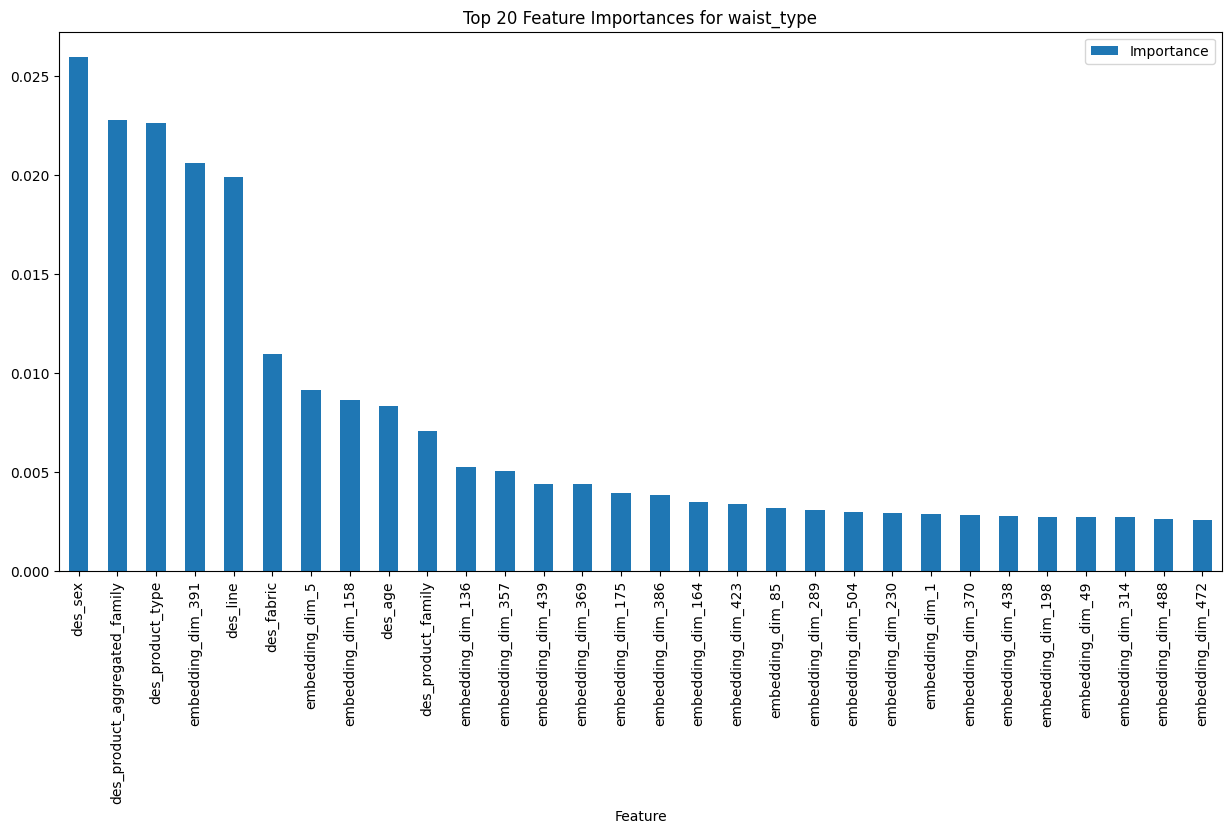

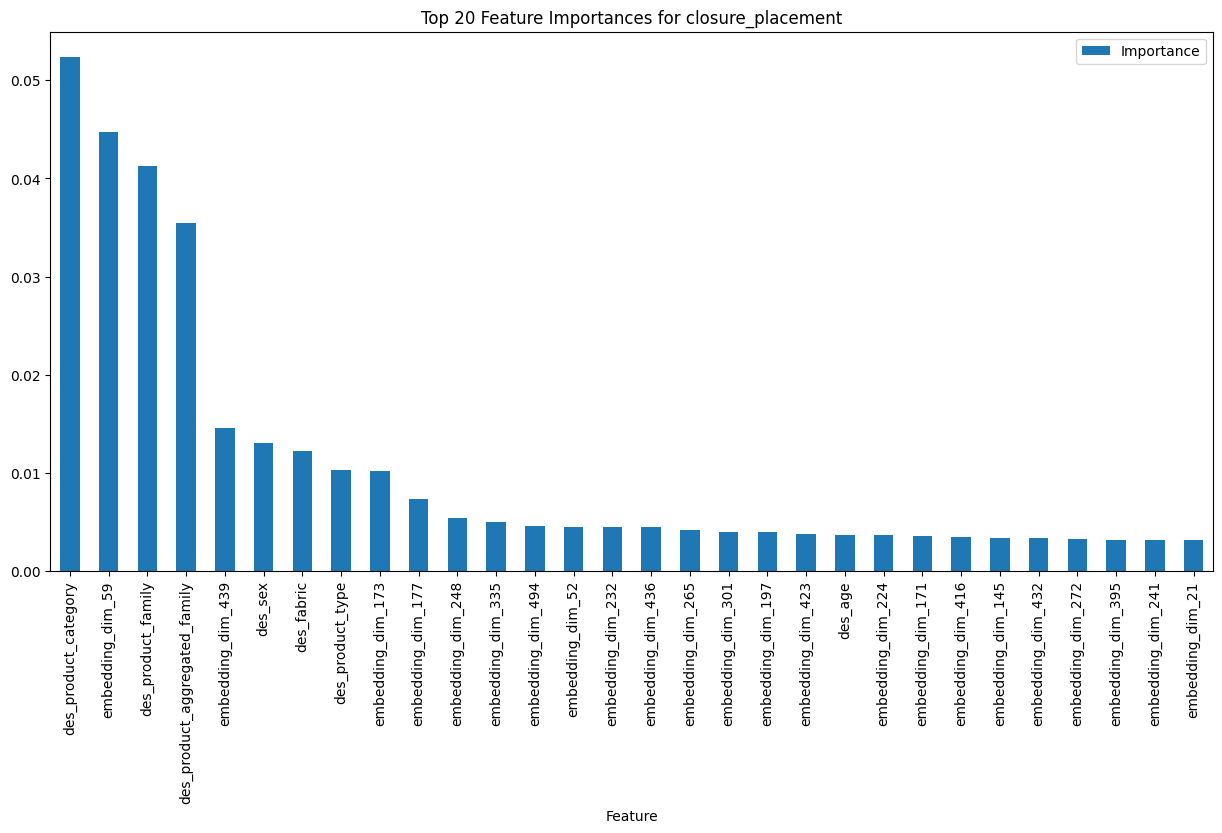

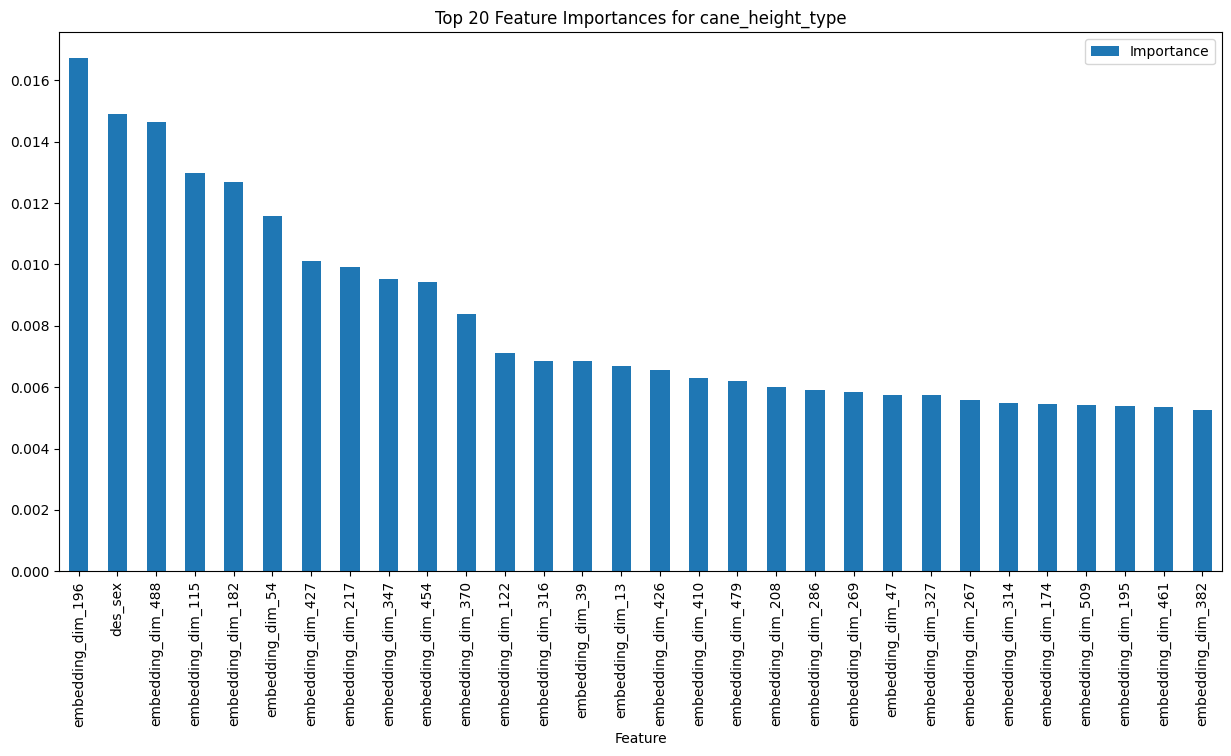

In [12]:
for label in labels:
    model = models[label]
    importances = model.feature_importances_
    feature_names = features.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    top_features = importance_df.head(30)
    # print(f"Top 20 feature importances for {label}:")
    # print(top_features)
    top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(15, 7), title=f'Top 20 Feature Importances for {label}')
    plt.show()